# Bike Sharing Linear Regression Model

## Importing and Understanding Data

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd

#importing below libraries to visualize data
import matplotlib.pyplot as plt 
import seaborn as sns

#to split data into train data and test data
from sklearn.model_selection import train_test_split

#to rescale features
from sklearn.preprocessing import MinMaxScaler

#Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#To ignore warnings because of version mismatch
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading day.csv file as df and viewing some sample records
df = pd.read_csv("day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Dataset characteristics	
#### day.csv have the following fields:	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	- weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [49]:
df.info()
#we don't see any null values and the dataset is clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## Visualizing Numerical vairables

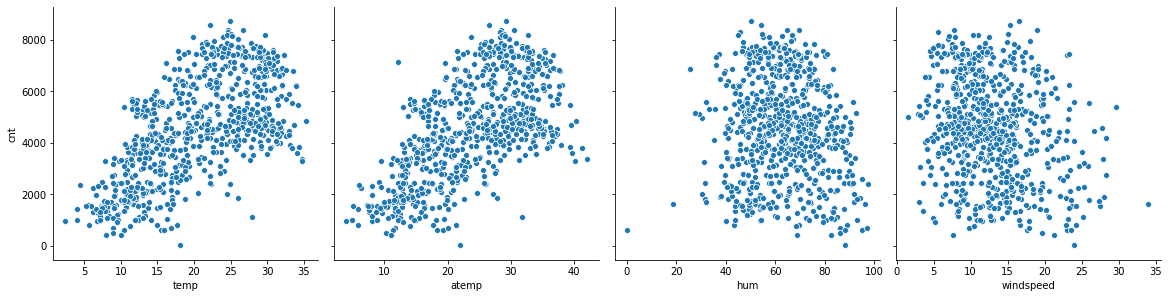

In [50]:
#visualizing the data to identify if some predictors are associated with cnt
sns.pairplot(df, x_vars=['temp', 'atemp', 'hum', 'windspeed'], y_vars='cnt',size=4, aspect=1, kind='scatter')
plt.show()


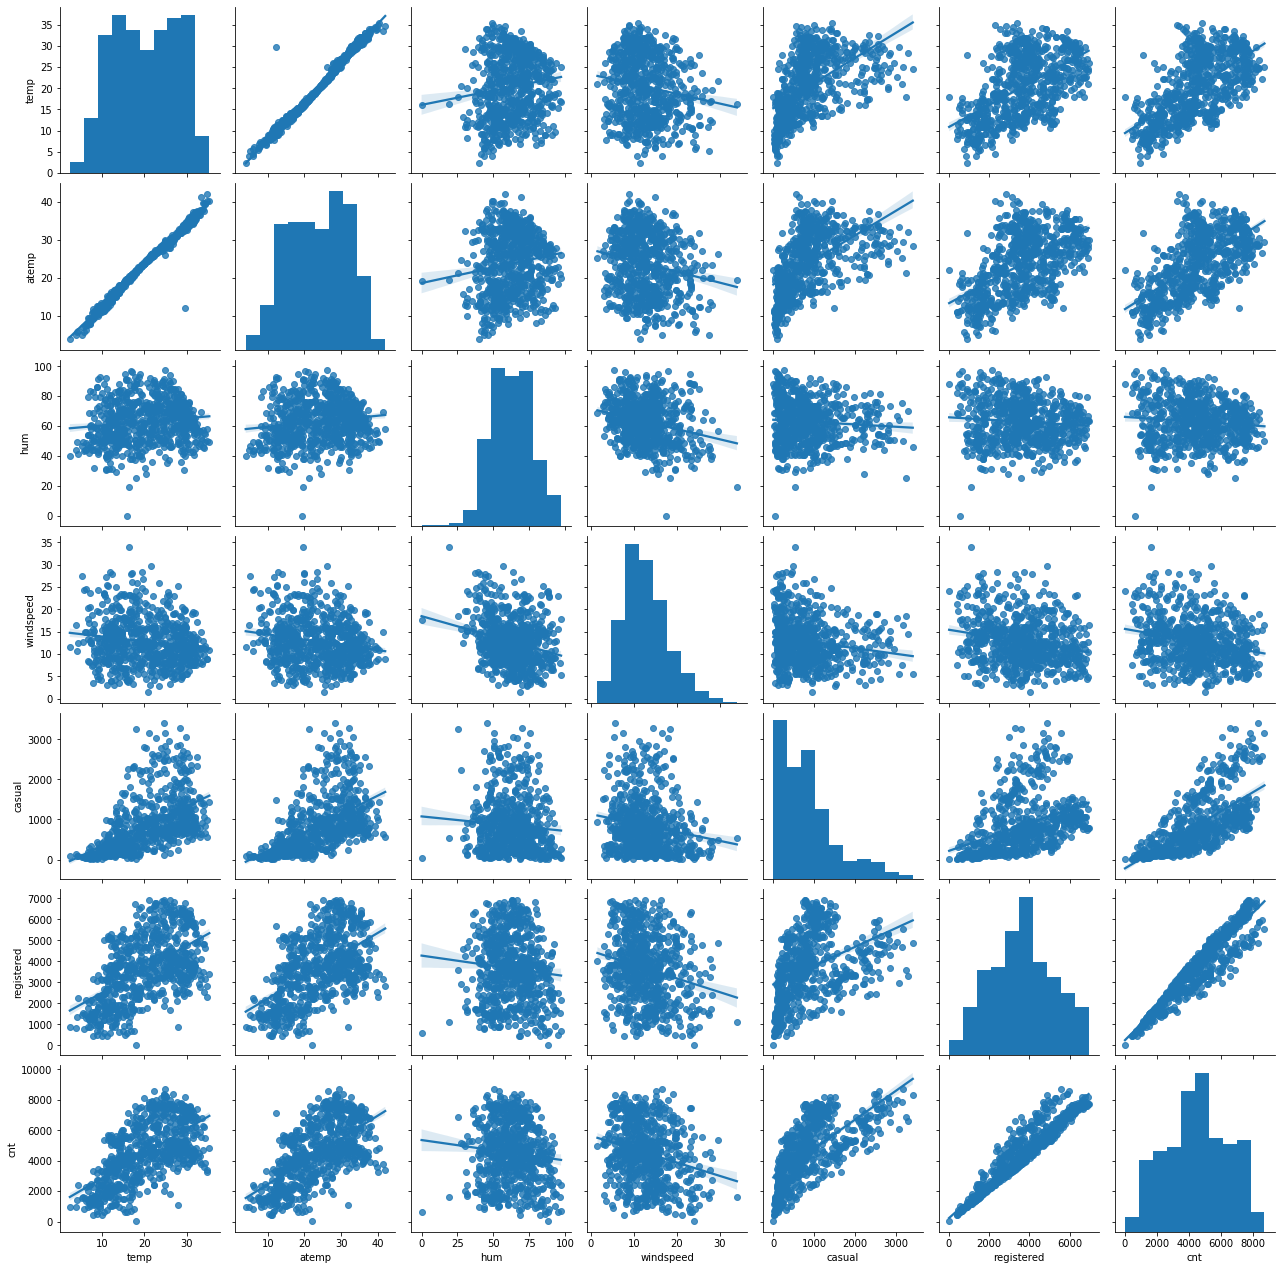

In [52]:
#visualizing numerical variables along with the regression lines
temp_df= df[["temp","atemp","hum","windspeed","casual","registered","cnt"]]
sns.pairplot(temp_df, kind="reg")


`temp` and `atemp` show similar pattern with respect to `cnt`

## Data Preparation

In [6]:
#converting season, weathersit, yr, holiday, weekday, workingday, mnth into identifiable categories as per dataset characteristics

df["season"]=df["season"].map({1:"Spring",2:"Summer",3:"Fall",4:'Winter'})

df["weathersit"]=df["weathersit"].map({1: 'Clear_Fc_Pc', 2: 'Mist_C_Bc_Fc', 3:'LightSnow_LR_Th_Sc', 4:'HeavyRain_IP_Th_M_S_F'})

df["yr"]=df["yr"].map({0:"2018",1:"2019"})

df["holiday"]=df["holiday"].map({0:"Working Time",1:"holiday"})

 #As per dataset 01-01-2018 is refered as 6 i.e Tuesday. Mappping has been followed accrodingly
df["weekday"]=df["weekday"].map({6:'Mon', 0:'Tues', 1:'Wed', 2:'Thurs', 3:'Fri', 4:'Sat', 5:'Sun'})

df["workingday"]=df["workingday"].map({0:"Non-Working",1:"Working"})

df["mnth"]=df["mnth"].map({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sept",10:"Oct",11:"Nov",12:"Dec"})

In [7]:
#viewing sample records
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,Spring,2018,Jan,Working Time,Mon,Non-Working,Mist_C_Bc_Fc,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,Spring,2018,Jan,Working Time,Tues,Non-Working,Mist_C_Bc_Fc,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,Spring,2018,Jan,Working Time,Wed,Working,Clear_Fc_Pc,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,Spring,2018,Jan,Working Time,Thurs,Working,Clear_Fc_Pc,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,Spring,2018,Jan,Working Time,Fri,Working,Clear_Fc_Pc,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Visualizing Categorical vairables

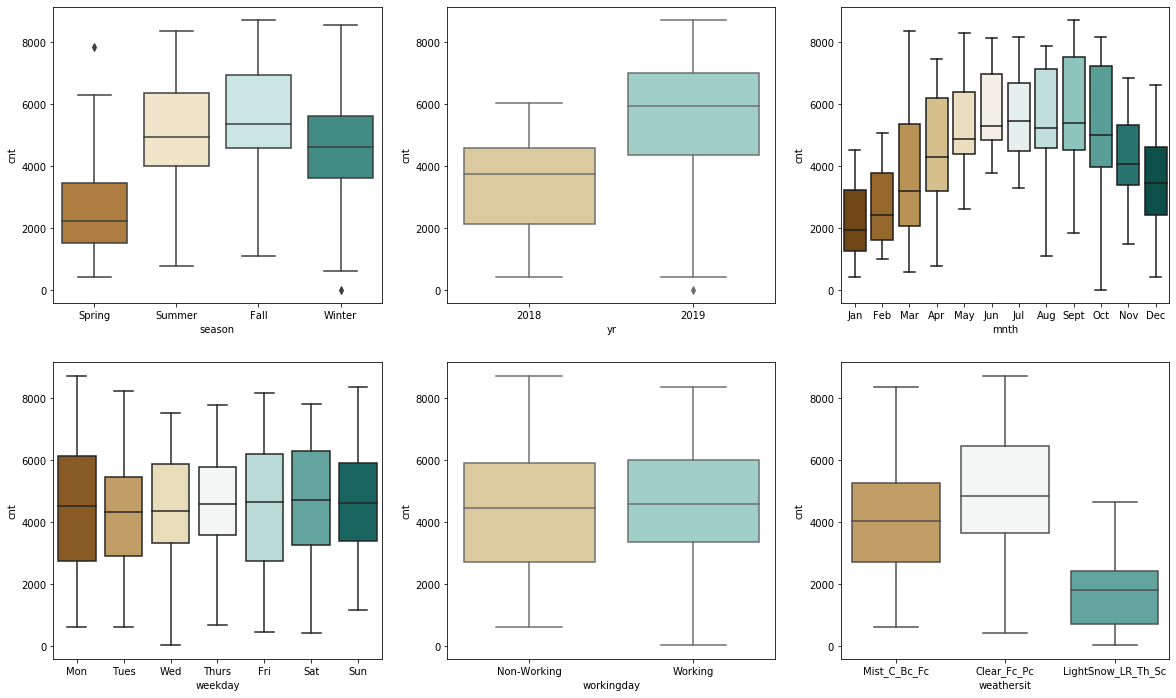

In [8]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'season' , y = 'cnt', data = df , palette='BrBG')
plt.subplot(2,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = df , palette='BrBG')
plt.subplot(2,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = df , palette='BrBG')
plt.subplot(2,3,4)
sns.boxplot(x = 'weekday', y = 'cnt', data = df , palette='BrBG')
plt.subplot(2,3,5)
sns.boxplot(x = 'workingday', y = 'cnt', data = df , palette='BrBG')
plt.subplot(2,3,6)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df , palette='BrBG')
plt.show()

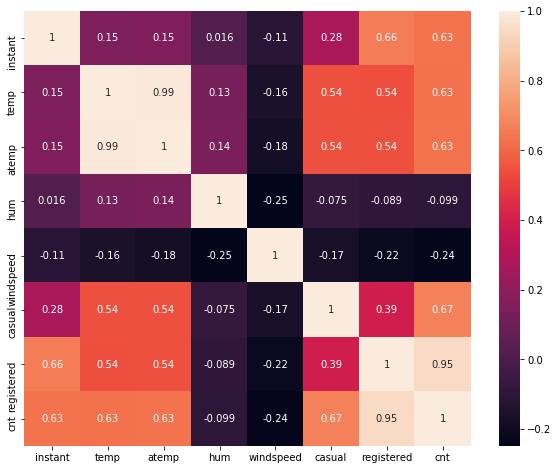

In [9]:
#finding the correlation matrix between variables using heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True)
plt.show()

#### Dropping unnecessary and redundant columns from the correlation analysis

In [10]:
#dropping 'instant' as it is an index column and with unique values
#dropping 'dteday' as it doesnot provide useful insights, which year/month would be able to provide
#dropping 'casual' and 'registered', as they are highly correlated with cnt, also cnt = casual + registered.
#dropping 'atemp' as it is highly correlated(0.99) with 'temp' variable and might cause multicollinearity.
#dropping 'holiday' as 97% of the values are same
cols=["instant","dteday","casual","registered","atemp","holiday"]
df.drop(cols,axis=1,inplace=True)

In [11]:
df.head()

,season,yr,mnth,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,Spring,2018,Jan,Mon,Non-Working,Mist_C_Bc_Fc,14.110847,80.5833,10.749882,985
1,Spring,2018,Jan,Tues,Non-Working,Mist_C_Bc_Fc,14.902598,69.6087,16.652113,801
2,Spring,2018,Jan,Wed,Working,Clear_Fc_Pc,8.050924,43.7273,16.636703,1349
3,Spring,2018,Jan,Thurs,Working,Clear_Fc_Pc,8.200000,59.0435,10.739832,1562
4,Spring,2018,Jan,Fri,Working,Clear_Fc_Pc,9.305237,43.6957,12.522300,1600


## Creating Dummy Variables

In [12]:
#considering all categorical columns
category_cols=["yr","season","mnth","weathersit","workingday","weekday"]

In [13]:
#creating Dummy Variables
dum_var=pd.get_dummies(df[category_cols] , drop_first=True)
dum_var.head()

,yr_2019,season_Spring,season_Summer,season_Winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,...,mnth_Sept,weathersit_LightSnow_LR_Th_Sc,weathersit_Mist_C_Bc_Fc,workingday_Working,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed
0,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [14]:
#concatinating to the df dataframe
df = pd.concat([df,dum_var],axis=1)
df.head()

,season,yr,mnth,weekday,workingday,weathersit,temp,hum,windspeed,cnt,...,mnth_Sept,weathersit_LightSnow_LR_Th_Sc,weathersit_Mist_C_Bc_Fc,workingday_Working,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed
0,Spring,2018,Jan,Mon,Non-Working,Mist_C_Bc_Fc,14.110847,80.5833,10.749882,985,...,0,0,1,0,1,0,0,0,0,0
1,Spring,2018,Jan,Tues,Non-Working,Mist_C_Bc_Fc,14.902598,69.6087,16.652113,801,...,0,0,1,0,0,0,0,0,1,0
2,Spring,2018,Jan,Wed,Working,Clear_Fc_Pc,8.050924,43.7273,16.636703,1349,...,0,0,0,1,0,0,0,0,0,1
3,Spring,2018,Jan,Thurs,Working,Clear_Fc_Pc,8.200000,59.0435,10.739832,1562,...,0,0,0,1,0,0,0,1,0,0
4,Spring,2018,Jan,Fri,Working,Clear_Fc_Pc,9.305237,43.6957,12.522300,1600,...,0,0,0,1,0,0,0,0,0,0


In [15]:
#dropping the original columns "yr","season","mnth","weathersit","workingday","weekday"
df=df.drop(category_cols,axis=1)
df.head()

,temp,hum,windspeed,cnt,yr_2019,season_Spring,season_Summer,season_Winter,mnth_Aug,mnth_Dec,...,mnth_Sept,weathersit_LightSnow_LR_Th_Sc,weathersit_Mist_C_Bc_Fc,workingday_Working,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed
0,14.110847,80.5833,10.749882,985,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,14.902598,69.6087,16.652113,801,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,8.050924,43.7273,16.636703,1349,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,8.200000,59.0435,10.739832,1562,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,9.305237,43.6957,12.522300,1600,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Splitting the Data into Training and Testing Sets

In [16]:
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling features

In [17]:
#applying MinMaxscaler to fit all the feature values between 0 and 1.
scaler = MinMaxScaler()

In [18]:
#rescaling 'temp','hum','windspeed','cnt' using MinMaxscaler
num_vars = ['temp','hum','windspeed','cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,temp,hum,windspeed,cnt,yr_2019,season_Spring,season_Summer,season_Winter,mnth_Aug,mnth_Dec,...,mnth_Sept,weathersit_LightSnow_LR_Th_Sc,weathersit_Mist_C_Bc_Fc,workingday_Working,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed
653,0.509887,0.575354,0.300794,0.864243,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
576,0.815169,0.725633,0.264686,0.827658,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
426,0.442393,0.640189,0.255342,0.465255,1,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
728,0.245101,0.498067,0.663106,0.204096,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
482,0.395666,0.504508,0.188475,0.482973,1,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0


### Dividing into X and Y sets for the model building

In [19]:
X_train = df_train
y_train = df_train.pop('cnt')

## Building linear model


In [20]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,10)
rfe = rfe.fit(X_train,y_train)

In [21]:
#fetching all informative features along with rank
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('yr_2019', True, 1),
 ('season_Spring', True, 1),
 ('season_Summer', False, 5),
 ('season_Winter', False, 4),
 ('mnth_Aug', False, 11),
 ('mnth_Dec', False, 8),
 ('mnth_Feb', False, 9),
 ('mnth_Jan', False, 6),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 17),
 ('mnth_Mar', False, 18),
 ('mnth_May', False, 10),
 ('mnth_Nov', False, 7),
 ('mnth_Oct', False, 14),
 ('mnth_Sept', True, 1),
 ('weathersit_LightSnow_LR_Th_Sc', True, 1),
 ('weathersit_Mist_C_Bc_Fc', True, 1),
 ('workingday_Working', False, 2),
 ('weekday_Mon', True, 1),
 ('weekday_Sat', False, 16),
 ('weekday_Sun', False, 15),
 ('weekday_Thurs', False, 13),
 ('weekday_Tues', False, 3),
 ('weekday_Wed', False, 12)]

In [22]:
#fetching all features that support
col = X_train.columns[rfe.support_]
col

Index(['temp', 'hum', 'windspeed', 'yr_2019', 'season_Spring', 'mnth_Jul',
       'mnth_Sept', 'weathersit_LightSnow_LR_Th_Sc', 'weathersit_Mist_C_Bc_Fc',
       'weekday_Mon'],
      dtype='object')

In [23]:
#creating train dataset with RFE selected variables
X_train_rfe1 = X_train[col]

In [24]:
#adding constant variable
X_train_rfe1 = sm.add_constant(X_train_rfe1)

### Building first model

In [25]:
#running first linearmodel
lm1 = sm.OLS(y_train,X_train_rfe1).fit()

In [26]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     241.6
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          4.33e-184
Time:                        11:53:18   Log-Likelihood:                 488.62
No. Observations:                 510   AIC:                            -955.2
Df Residuals:                     499   BIC:                            -908.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.3766      0.030     12.421      0.000       0.317       0.436
temp                              0.4091      0.027     15.413      0.000       0.357       0.461
hum                              -0.1247      0.038     -3.244      0.001      -0.200      -0.049
windspeed                        -0.1802      0.026     -6.805      0.000      -0.232      -0.128
yr_2019                           0.2332      0.008     27.653      0.000       0.217       0.250
season_Spring                    -0.1483      0.012    -11.944      0.000      -0.173      -0.124
mnth_Jul                         -0.0794      0.018     -4.464      0.000      -0.114      -0.044
mnth_Sept                         0.0553      0.016      3.445      0.001       0.024       0.087
weathersit_LightSnow_LR_Th_Sc    -0.2402      0.027     -8.778      0.000      -0.294      -0.186
weathersit_Mist_C_Bc_Fc          -0.0607      0.011     -5.610      0.000      -0.082      -0.039
weekday_Mon                       0.0212      0.012      1.842      0.066      -0.001       0.044
==============================================================================
Omnibus:                       59.213   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.976
Skew:                          -0.640   Prob(JB):                     5.97e-29
Kurtosis:                       5.116   Cond. No.                         18.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
#removing 'const' to calculate VIF
X_train_temp = X_train_rfe1.drop(["const"], axis = 1)

In [28]:
#function to calculate VIF
def calVIF(X_trainVIFCalc):
    vif = pd.DataFrame()
    X = X_trainVIFCalc
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [29]:
calVIF(X_train_temp)

,Features,VIF
1,hum,14.91
0,temp,11.88
2,windspeed,3.98
8,weathersit_Mist_C_Bc_Fc,2.10
3,yr_2019,2.03
4,season_Spring,1.84
5,mnth_Jul,1.40
6,mnth_Sept,1.20
7,weathersit_LightSnow_LR_Th_Sc,1.20
9,weekday_Mon,1.18


### Builiding second model after removing 'hum' feature

In [30]:
#dropping 'hum' as the VIF is high
X_train_rfe2 = X_train_rfe1.drop(["hum"], axis = 1)

In [31]:
#adding constant variable
X_train_rfe2 = sm.add_constant(X_train_rfe2)

In [32]:
#running second linearmodel after dropping hum
lm2 = sm.OLS(y_train,X_train_rfe2).fit()

In [33]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     262.3
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          4.65e-183
Time:                        11:53:19   Log-Likelihood:                 483.30
No. Observations:                 510   AIC:                            -946.6
Df Residuals:                     500   BIC:                            -904.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.2999      0.019     15.650      0.000       0.262       0.338
temp                              0.3954      0.026     14.948      0.000       0.343       0.447
windspeed                        -0.1546      0.026     -6.059      0.000      -0.205      -0.105
yr_2019                           0.2361      0.008     27.869      0.000       0.219       0.253
season_Spring                    -0.1458      0.013    -11.658      0.000      -0.170      -0.121
mnth_Jul                         -0.0734      0.018     -4.109      0.000      -0.108      -0.038
mnth_Sept                         0.0528      0.016      3.264      0.001       0.021       0.085
weathersit_LightSnow_LR_Th_Sc    -0.2756      0.025    -10.878      0.000      -0.325      -0.226
weathersit_Mist_C_Bc_Fc          -0.0806      0.009     -8.943      0.000      -0.098      -0.063
weekday_Mon                       0.0230      0.012      1.978      0.048       0.000       0.046
==============================================================================
Omnibus:                       62.910   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.497
Skew:                          -0.678   Prob(JB):                     1.39e-30
Kurtosis:                       5.152   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
#removing 'const' to calculate VIF
X_train_temp = X_train_rfe2.drop(["const"], axis = 1)

In [35]:
calVIF(X_train_temp)

,Features,VIF
0,temp,4.63
1,windspeed,3.85
2,yr_2019,2.03
3,season_Spring,1.52
7,weathersit_Mist_C_Bc_Fc,1.48
4,mnth_Jul,1.33
5,mnth_Sept,1.20
8,weekday_Mon,1.18
6,weathersit_LightSnow_LR_Th_Sc,1.06


## Residual Analysis of the train data

In [36]:
#predicting the model
y_train_cnt = lm2.predict(X_train_rfe2)

Text(0.5, 0, 'Errors')

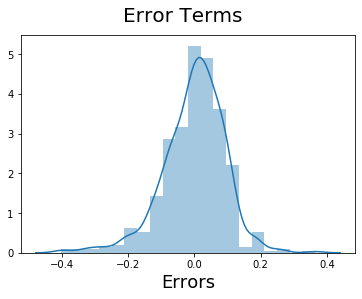

In [37]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

## Making Predictions using the final model

#### Applying the scaling on the test sets

In [38]:
num_vars = ['temp','hum','windspeed','cnt']

df_test[num_vars] = scaler.transform(df_test[num_vars])

#### Dividing into X_test and y_test

In [39]:
X_test = df_test
y_test = df_test.pop('cnt')

In [40]:
X_train_temp.columns

Index(['temp', 'windspeed', 'yr_2019', 'season_Spring', 'mnth_Jul',
       'mnth_Sept', 'weathersit_LightSnow_LR_Th_Sc', 'weathersit_Mist_C_Bc_Fc',
       'weekday_Mon'],
      dtype='object')

In [41]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe with only finalised features
X_test_new = X_test[X_train_temp.columns]

# Adding a constant variable
X_test_new = sm.add_constant(X_test_new)

In [42]:
# Making predictions
y_pred = lm2.predict(X_test_new)

## Model Evaluation

Text(0, 0.5, 'y_pred')

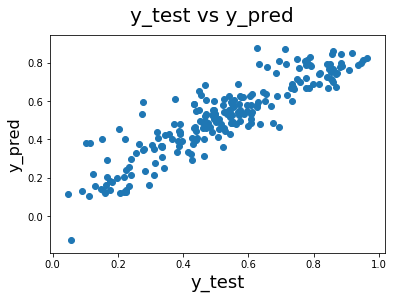

In [43]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

#### Calculating RMSE

In [44]:
#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(y_test, y_pred))

0.09701641737588003

#### Checking the R-squared on the test set

In [45]:
r_squared = r2_score(y_test, y_pred)
r_squared

0.8018312434926996

#### R-Squared on Train set = 0.825
#### R-Squared on Test set = 0.801


# Conclusion

`After interpreting the coefficients the following can be inferred:`

1.) Holding all other features fixed, a unit increase in `temp` is associated with **0.3954** increase in demand for shared bikes.<br>
2.) Holding all other features fixed, a unit increase in `weathersit_LightSnow_LR_Th_Sc` is associated with **0.2756** decrease in demand for shared bikes.<br>
3.) Holding all other features fixed, a unit increase in `yr_2019` is associated with **0.2361** increase in demand for shared bikes.<br>
4.) Holding all other features fixed, a unit increase in `windspeed` is associated with **0.1546** decrease in demand for shared bikes.<br>
5.) Holding all other features fixed, a unit increase in `season_Spring` is associated with **0.1458** decrease in demand for shared bikes.<br>